# Identificação do modelo linear das taxas

Os dados de entrada correspondem à resposta em frequência obtidos com o script `analise_resposta_em_freq.ipynb`.
Será analisada a taxa `p` variação do ângulo de rolagem.

TODO: Corrigir a simulação no tempo do modelo linear. PArece ter um bias e um ganho faltando.
TODO: Revisar o clipping e a condição inicial da simulação!

In [106]:
import pandas as pd
import matplotlib
matplotlib.use('TkAgg')  # Configurar o backend para TkAgg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid, quad
from myfunctions import read_ulog, list_all_fields, get_ulog_data, butter_lowpass_filter

In [107]:
# Carrega os dados de 'dados/freq_rad_p_rate.txt'
df_freq = pd.read_csv('dados/freq_rad_s_p_rate.txt')
freq_rad = df_freq.iloc[:, 0].astype(float)

# Carrega os dados de 'dados/modulo_dB_p_rate.txt'
df_modulo = pd.read_csv('dados/modulo_dB_p_rate.txt')
modulo_dB = df_modulo.iloc[:, 0].astype(float)

# Carrega os dados de 'dados/fase_rad_p_rate.txt'
df_fase = pd.read_csv('dados/fase_rad_p_rate.txt')
fase_deg = df_fase.iloc[:, 0].astype(float)

# Modelo da dinâmica da taxa p
$$
\dfrac{P(s)}{U(s)}=\dfrac{e^{-\tau s}}{I_{xx}s}
$$

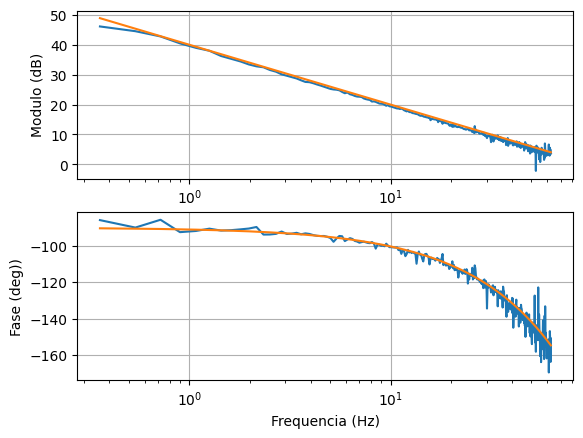

In [108]:
K = 100 # 1/Ixx
tau = 0.018
a = 0.4
def tf(w):
    s = complex(0,w)
    return K*np.exp(-tau*s) / (s)
# Calcula a resposta em frequência de tf
mod_tf_dB = np.zeros(len(freq_rad))
tf_fase = np.zeros(len(freq_rad))
for i in range(len(freq_rad)):
    mod_tf_dB[i] = 20*np.log10(abs(tf(freq_rad[i])))
    tf_fase[i] = np.angle(tf(freq_rad[i]))*180/np.pi
# grafico de Bode
plt.figure()
plt.subplot(2, 1, 1)
plt.semilogx(freq_rad, modulo_dB)
plt.semilogx(freq_rad, mod_tf_dB)
plt.grid()
plt.ylabel('Modulo (dB)')
plt.subplot(2, 1, 2)
plt.semilogx(freq_rad, fase_deg)
plt.semilogx(freq_rad, np.unwrap(tf_fase))
plt.grid()
plt.ylabel('Fase (deg))')
plt.xlabel('Frequencia (Hz)')
plt.show()

O modelo linear identificado para $P(s)$ é:
$$
sP(s)=\dfrac{1}{I_{xx}}e^{-\tau s}U(s)
$$
com $I_{xx}=0.01$ e $\tau=0.018$. Das propriedades da transformada de Laplace, podemos obter o modelo linear no domínio do tempo para $p(t)$:
$$
\dot{p}(t)=\dfrac{1}{I_{xx}}u(t-\tau).
$$

# Validação do modelo no domínio do tempo
Comparamos a resposta do modelo obtido com a resposta real utilizando um sinal de entrada diferente do utilizado para obter a responta em frequência.

In [109]:
# Para esse test utilizamos o seguinte conjunto de dados
file_path = 'ulogs/log_1_2024-9-3-07-56-31.ulg' # double sawtooth signal 0k! Tem poucos harmônicos
# Ler o arquivo .ulg
ulog = read_ulog(file_path)

In [110]:
# Coletar os dados dos atuadores
timestamps_c0, control0 = get_ulog_data(ulog, 'actuator_motors', 'control[0]')
timestamps_c1, control1 = get_ulog_data(ulog, 'actuator_motors', 'control[1]')
timestamps_c2, control2 = get_ulog_data(ulog, 'actuator_motors', 'control[2]')
timestamps_c3, control3 = get_ulog_data(ulog, 'actuator_motors', 'control[3]')

# Coletar os dados das taxas de rotação
timestamps_vav0, vav0 = get_ulog_data(ulog, 'vehicle_angular_velocity', 'xyz[0]')

In [111]:
dt_controle = timestamps_c0[1] - timestamps_c0[0]  # Período de amostragem dos dados
t_controle = np.linspace(0, len(control0)*dt_controle, len(control0))  # Vetor de tempo
#
dt_taxas = timestamps_vav0[1] - timestamps_vav0[0]  # Período de amostragem dos dados
t_taxas = np.linspace(0, len(vav0)*dt_taxas, len(vav0))  # Vetor de tempo

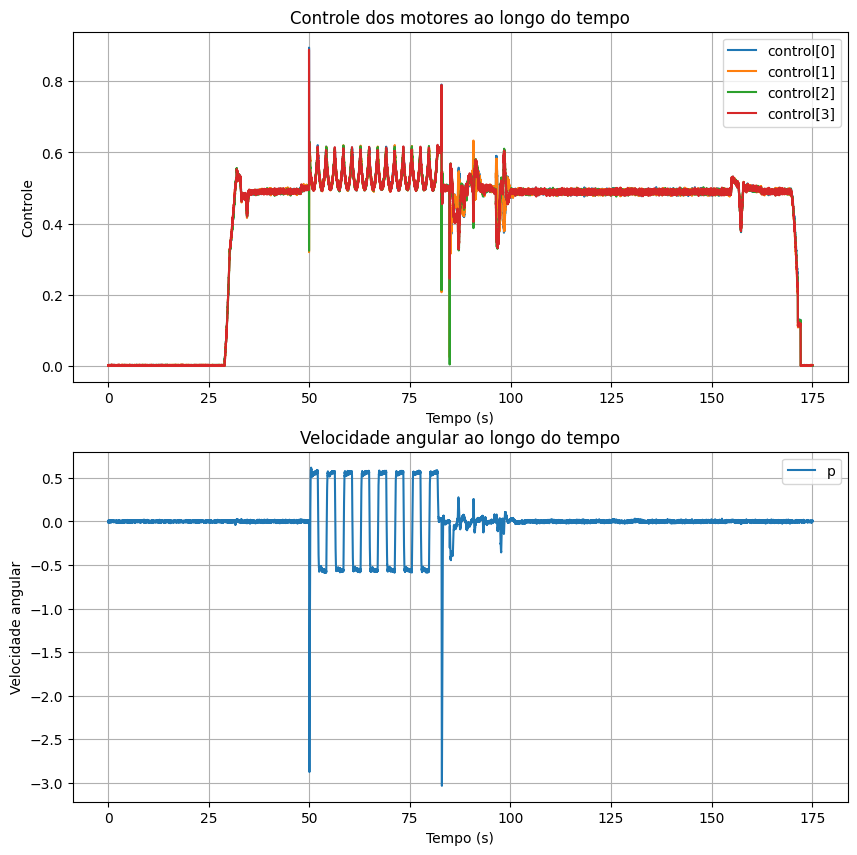

In [112]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
#
ax1.plot(t_controle, control0, label='control[0]')
ax1.plot(t_controle, control1, label='control[1]')
ax1.plot(t_controle, control2, label='control[2]')
ax1.plot(t_controle, control3, label='control[3]')
#
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Controle')
ax1.set_title('Controle dos motores ao longo do tempo')
ax1.legend()
ax1.grid()
#
ax2.plot(t_taxas, vav0, label='p')
#
ax2.set_xlabel('Tempo (s)')
ax2.set_ylabel('Velocidade angular')
ax2.set_title('Velocidade angular ao longo do tempo')
ax2.legend()
ax2.grid()
#
#plt.tight_layout()
plt.show()
#  

In [123]:
# Recortando os dados para análise
t0_clip = 54.0
t1_clip = 80.0 #t0_clip + 15.0
#
t_cont_clipped = t_controle[(t_controle >= t0_clip) & (t_controle <= t1_clip)] - t0_clip   # Recortando o vetor de tempo
controle0_clipped = control0[(t_controle >= t0_clip) & (t_controle <= t1_clip)] - np.mean(control0[(t_controle >= t0_clip) & (t_controle <= t1_clip)]) 
controle1_clipped = control1[(t_controle >= t0_clip) & (t_controle <= t1_clip)] - np.mean(control1[(t_controle >= t0_clip) & (t_controle <= t1_clip)]) 
controle2_clipped = control2[(t_controle >= t0_clip) & (t_controle <= t1_clip)] - np.mean(control2[(t_controle >= t0_clip) & (t_controle <= t1_clip)]) 
controle3_clipped = control3[(t_controle >= t0_clip) & (t_controle <= t1_clip)] - np.mean(control3[(t_controle >= t0_clip) & (t_controle <= t1_clip)]) 
# 
controle_clipped = controle1_clipped + controle2_clipped - controle0_clipped - controle3_clipped
# recortando as taxas de rotação
t_taxas_clipped = t_taxas[(t_taxas >= t0_clip) & (t_taxas <= t1_clip)] - t0_clip   # Recortando o vetor de tempo
vav0_clipped = vav0[(t_taxas >= t0_clip) & (t_taxas <= t1_clip)]  # Recortando as taxas de rotação

In [120]:
# Calculo da condição incial do sinal de controle.
# é calculada como a media dos valores de controle no intervalo de tempo [t0_clip, t0_clip+dt_controle]
controle_ic = np.mean([control0[(t_controle >= t0_clip)&(t_controle <= t0_clip+dt_controle)],
         control1[(t_controle >= t0_clip)&(t_controle <= t0_clip+dt_controle)],
         control2[(t_controle >= t0_clip)&(t_controle <= t0_clip+dt_controle)],
         control3[(t_controle >= t0_clip)&(t_controle <= t0_clip+dt_controle)]])

In [121]:
# Filtrando os sinais
cutoff_freq = 10.0 # Hz
controle0_clipped_filt = butter_lowpass_filter(controle0_clipped, cutoff_freq, 1/dt_controle, order=5)
controle1_clipped_filt = butter_lowpass_filter(controle1_clipped, cutoff_freq, 1/dt_controle, order=5)
controle2_clipped_filt = butter_lowpass_filter(controle2_clipped, cutoff_freq, 1/dt_controle, order=5)
controle3_clipped_filt = butter_lowpass_filter(controle3_clipped, cutoff_freq, 1/dt_controle, order=5)
#
controle_clipped_filtered = controle1_clipped_filt + controle2_clipped_filt - controle0_clipped_filt - controle3_clipped_filt
#
vav0_clipped_filtered = butter_lowpass_filter(vav0_clipped, cutoff_freq, 1/dt_taxas, order=5)    

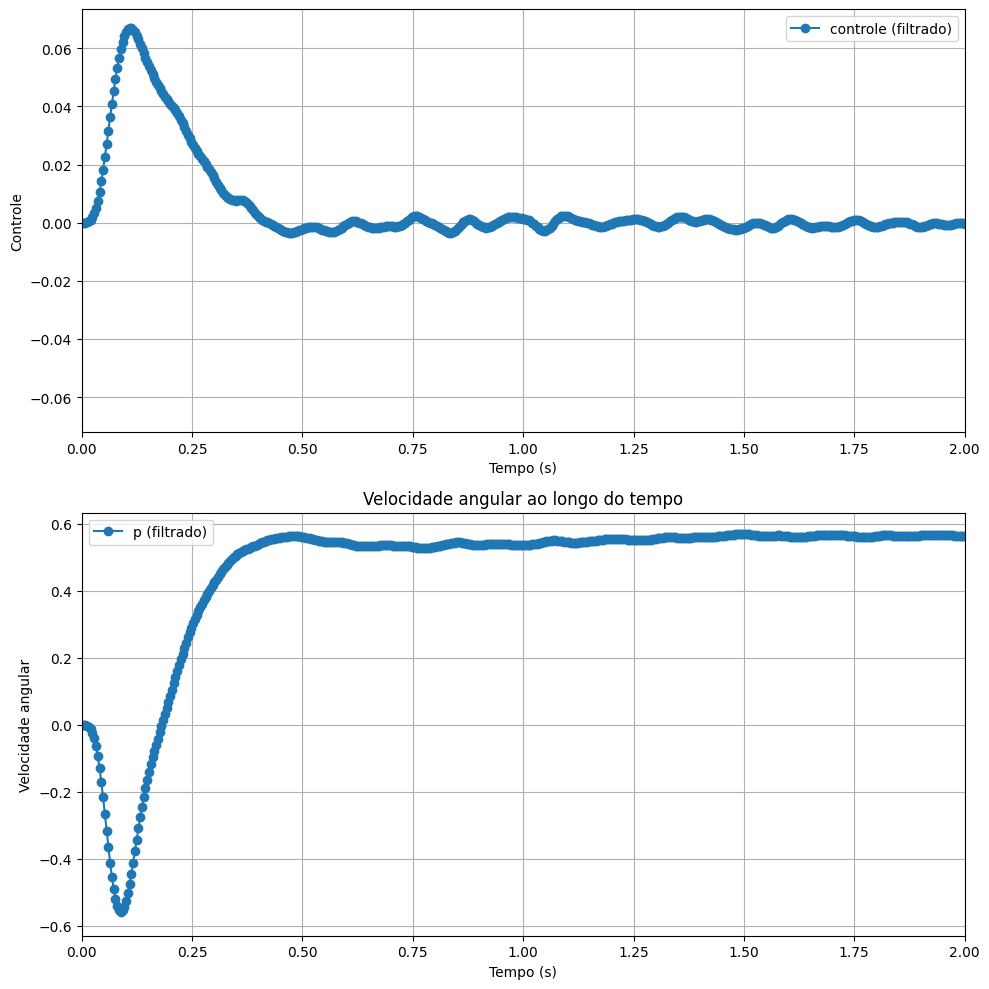

In [122]:
# Plotando os dados recortados
fig, (ax2, ax3) = plt.subplots(2, 1, figsize=(10, 10))
#
#ax2.plot(t_cont_clipped, controle0_clipped_filt, label='control[0] (filtrado)')
#ax2.plot(t_cont_clipped, controle1_clipped_filt, label='control[1] (filtrado)')
#ax2.plot(t_cont_clipped, controle2_clipped_filt, label='control[2] (filtrado)')
#ax2.plot(t_cont_clipped, controle3_clipped_filt, label='control[3] (filtrado)')
ax2.plot(t_cont_clipped, controle_clipped_filtered, label='controle (filtrado)', marker='o')
ax2.set_xlabel('Tempo (s)')
ax2.set_ylabel('Controle')
ax2.set_xlim([0, 2])
ax2.legend()
ax2.grid()
#
#ax3.plot(t_taxas_clipped, vav0_clipped, label='p')
ax3.plot(t_taxas_clipped, vav0_clipped_filtered, label='p (filtrado)', marker='o')
#ax3.plot(t_taxas_clipped, vav1_clipped, label='q')
#ax3.plot(t_taxas_clipped, vav2_clipped, label='r')
ax3.set_xlabel('Tempo (s)')
ax3.set_ylabel('Velocidade angular')
ax3.set_title('Velocidade angular ao longo do tempo')
ax3.set_xlim([0, 2])
ax3.legend()
ax3.grid()  
#
plt.tight_layout()
plt.show()

Para computar $p(t)$ fazemos:
$$
\int_{0}^{t}\dot{p}(\xi)d\xi=\dfrac{1}{I_{xx}}\int_{0}^{t}u(\xi-\tau)d\xi,
$$
$$
p(t)=\dfrac{1}{I_{xx}}\int_{0}^{t}u(\xi-\tau)d\xi+p(0),
$$
fazendo a mudança de variável: $\lambda=\xi-\tau$, temos $\xi=\lambda+\tau$ e $d\xi = d\lambda$. Quando $\xi\to0:\lambda\to-\tau$, e uando $\xi\to t:\lambda\to t-\tau$, 
$$
p(t)=\dfrac{1}{I_{xx}}\int_{-\tau}^{t-\tau}u(\lambda)d\lambda+p(0),
$$


In [117]:
# definir uma função de interporlação para os dados filtrados
entrada_u = interp1d(t_cont_clipped, controle_clipped_filtered, kind='linear', fill_value='extrapolate')

# Os parametros do modelo sâo
Ixx = 0.01 # e 
tau = 0.018
ic = vav0_clipped_filtered[0]

# aplicamos a função de interpolação para obter a entrada u(t-tau)  
entrada_u_delay_tau = entrada_u(t_cont_clipped - tau)

integral_cumulativa = cumulative_trapezoid(entrada_u_delay_tau, t_cont_clipped, dt_controle ,initial=0) 

# Calcular o modelo p(t) ao longo do tempo
p_modelo = (1/Ixx) * integral_cumulativa + ic

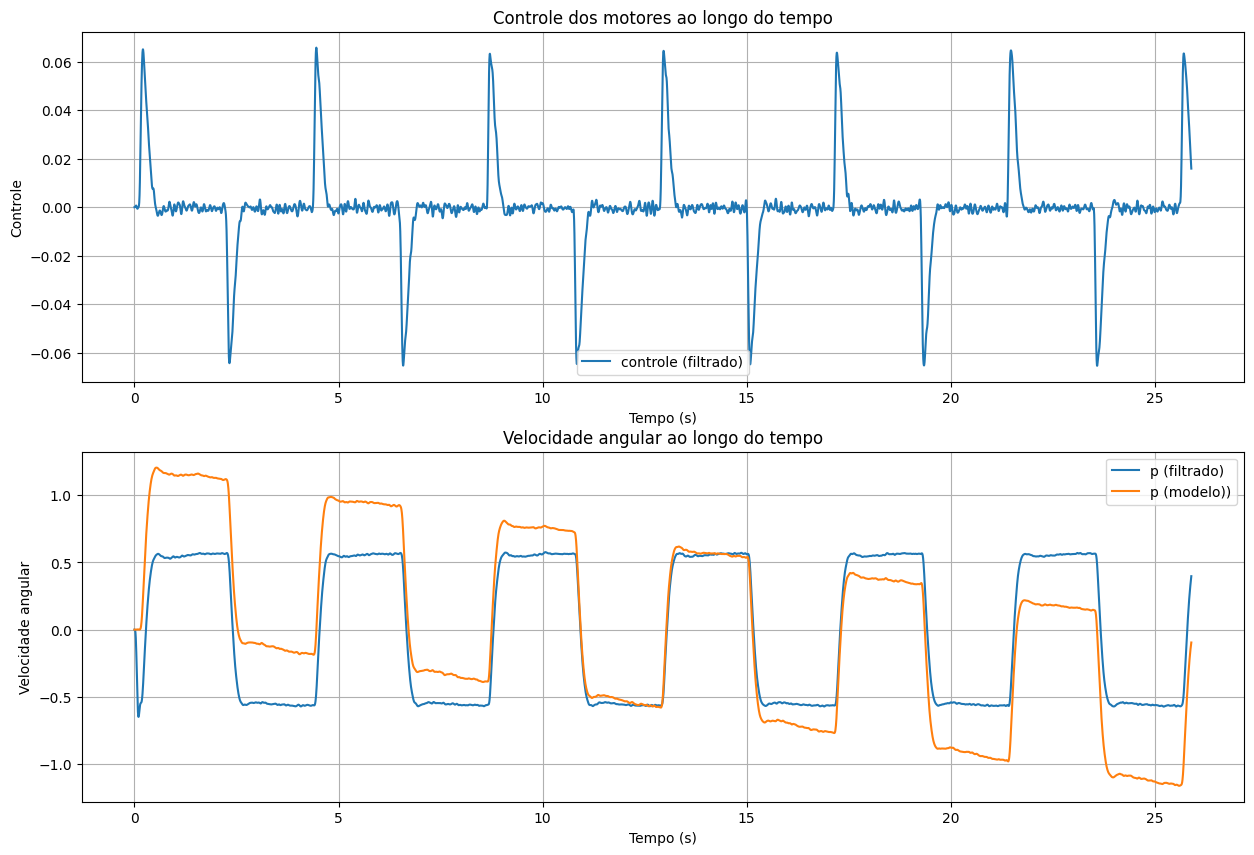

In [118]:
# Plotando os dados recortados
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
#
ax1.plot(t_cont_clipped, controle_clipped_filtered, label='controle (filtrado)')
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Controle')
ax1.set_title('Controle dos motores ao longo do tempo')
ax1.legend()
ax1.grid()
#
ax2.plot(t_taxas_clipped, vav0_clipped_filtered, label='p (filtrado)')
ax2.plot(t_cont_clipped, p_modelo, label='p (modelo))')
ax2.set_xlabel('Tempo (s)')
ax2.set_ylabel('Velocidade angular')
ax2.set_title('Velocidade angular ao longo do tempo')
#ax2.set_ylim([-1, 1])
ax2.legend()
ax2.grid()
#

